In [1]:
# Imports
# Do NOT import anything else
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pca import pca
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble        import RandomForestRegressor, StackingRegressor, BaggingRegressor
from sklearn.linear_model    import LogisticRegression, RidgeClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
from   sklearn.pipeline           import Pipeline, FeatureUnion
from sklearn.preprocessing   import *
from sklearn.inspection import permutation_importance
from sklearn.base import clone 
from   sklearn.metrics            import accuracy_score # We have not covered it yet in class. The basics - AUC is from 0 to 1 and higher is better.
from sklearn.inspection            import permutation_importance

from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
import rfpimp
import seaborn as sns
from scipy import stats



/Users/Evan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
%run featimp

# Feature Selection
**Purpose**: Choose the columns that have the highest impact on a model's predictability and drop the ones that have low predictive power. <br>
**Background/Explanation**: Why should you include a feature in a model if it has no predictive power. Not only does this introduce complexity to the model, but it increases training time that adds no value to model performance. Therefore, it is important to understand and interpret a feature's importance in its ability to predict a desired target variable.
**Methods**: 
1) Spearman's Rank correlation coefficient <br>
2) PCA <br>
3) Drop Column Importance <br> 
4) Permutation Importance <br>


**Side Note**: Gradient boosting algorithms such as XGBoost, and Light Gradient Boosting Machine have regularization parameters to tune. Therefore, feature selection is not important when gradient boosting algorithms are inherently able to determine feature importance. Additionally, XGBoost and LGBM are tree-based algorithms that perform "bagging" of individual trees to increase generality. 

# 1) Spearman's Rank-order Correlation Coefficient (Spearman's R)
**Purpose**: Quantify the strength of association between 2 variables. <br>
**Background/Explanation**: Spearman's R is a nonparametric measure of correlation. Recall that nonparametric means that there are no assumptions about the underlying distribution of values that can be estimated with a set of parameters. For example, if a feature's values are assumed to be normally distributed, we can estimate the population parameters with a mean and variance. The Spearman's R, ranges from -1 to 1; therefore, we take the absolute value to determine a feature's association with the target. The closer a column's Spearman's R number is to 0, the weaker the association between the feature and target variable. <br>
**Method:** 
1) Run Spearman's R for each column's values against the target variable. <br>
2) Take the absolute value of the Spearman's R for each column. <br>
3) Sort the columns with the highest values from highest to lowest correlation. <br>

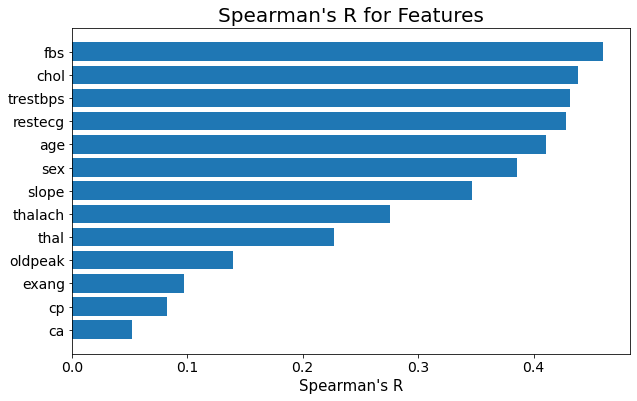

In [10]:
spearman = get_spearman(X)
spear_cols = [x[0] for x in spearman]
spearman_values = [x[1] for x in spearman]
spearman_values.reverse()
plot_spearman(spear_cols, spearman_values)

# 2) **Principal Component Analysis (PCA)**

**Purpose:** Project the data into a lower-dimensional feature-space while aiming to preserve as much variance <br>
**Background/Explanation:**  The reason we want to preserve the data's variance is because  variance within a feature is what gives a model predicting power. To explain this further it is helpful to think of the opposite extreme each feature column has a uniform distribution, yet the target we are trying to predict is not uniform observations. The uniform distribution means the column does not have any predictive power on the y-variable.  <br>
**Method:**
1) Initialize PCA model with **n_components**.  This gives you the amount of variance from the available features you want to retain. <br>
2) Obtain top features. <br>

**Warnings**: Once the dimmensionality has been reduced to the principal components, we lose interpretability because of the transformed space


In [4]:
df = pd.read_csv('heart.csv')
df.columns
X = df.drop(columns='target')
y = df.target.values

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

model = pca(n_components=0.95)
results = model.fit_transform(X)
df_importance = results['topfeat']
PCA_features = list(df_importance['feature'].values)
print("Features Sorted in Importance by PCA:", PCA_features)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [13] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [3] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
Features Sorted in Importance by PCA: ['chol', 'thalach', 'trestbps', 'age', 'oldpeak', 'cp', 'ca', 'thal', 'restecg', 'slope', 'sex', 'exang', 'fbs']


# 3) Drop Column Importance


**Purpose:** Quantify the effect on a model's performance when a particular feature is excluded.  <br>
**Background/Explanation:** Though not quite a measure of a feature's importance, we can quantify a feature's affect on a model's performance by evaluating the feature's exclusion when compared to the baseline model's performance when all feature are included. We ensure to clone the model before evaluating how it performs with a column dropped to ensure that the parameters are the same, which removes extraneous variables that contribute to the metric <br>

**Method:** 
1) Select proper metric for evaluating model performance with all features included. <br>
2) Drop a feature column and retrain the model with remaining features. <br>
3) Compare the new model's evaluation metric when   

**Additional Information**: Because the concept is simple, it is relatively easy to implement in code; however, retraining the model each time means that this process can become very computationally expensive if we have many features. <br>
**WARNINGS:** Drop Column Importance is only effective when we assume that the features are independent of each. It is not effective when there is multicollinearity between feature columns. 

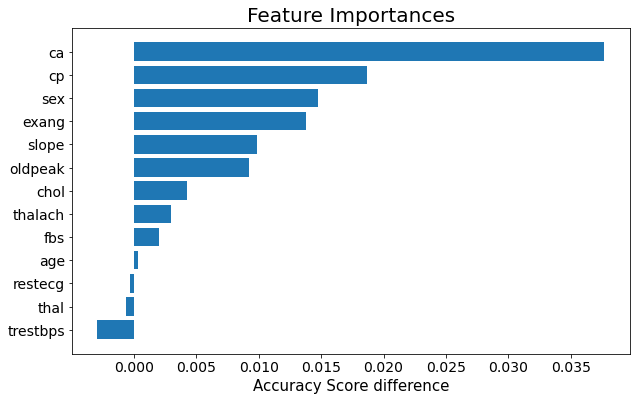

In [5]:
# Get average over 50 iterations
n = 50
bench_scores = []
dropped_scores = np.zeros(shape=(n,len(X.columns)))
for i in range(n):
    bench_score, dropped_score = drop_col(model=RandomForestClassifier())  # call drop_col function
    bench_scores.append(bench_score)
    dropped_scores[i] = dropped_score

bench_avg = np.mean(bench_scores)
dropped_avg = np.mean(dropped_scores, axis=0)
dropped_avg = [(col, score) for col, score in zip(X.columns, dropped_avg)]
plot_importances(bench_avg, dropped_avg)

# 4) Permutation Importance

**Purpose:** Examine a feature's importance by randomly permuting the validation set's feature column's values <br>
**Background/Explanation:**   When you train a model with a feature column, we are assuming that there is some value in the feature in its ability to predict target variable. How do you void the feature's ability to predict. You can simply randomly shuffle the feature column's values in the validation set. The feature's supposed ability to predict the target variable should be reduced to 0 with some random noise. <br>
**Method:** 
1) Obtain benchmark model perfomance with all features. <br>
2) Randomly permute the validation set's column's values and reassig.. <br>
3) Subtract the metric form the benchmark. <br>

**Additional Information:** There is no need to retrain a model so this method is faster than drop-column importance. <br>
**WARNINGS:** Permutation Importance is only effective when we assume that the features are independent of each. It is not effective when there is multicollinearity between feature columns. 

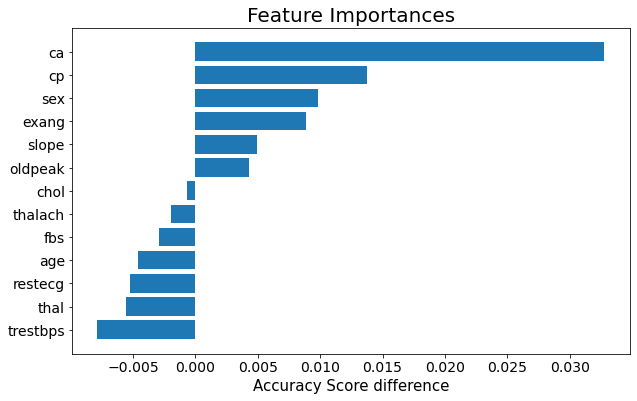

In [6]:
# Get average over 50 iterations 
n = 50
bench_scores = []
permuted_scores = np.zeros(shape=(n,len(X.columns)))
for i in range(n):
    bench_score, permute_score = permute_col(X, y, model=RandomForestClassifier())   # Call permute_col function
    bench_scores.append(bench_score)
    permuted_scores[i] = permute_score
bench_avg = np.mean(bench_scores)
permute_avgs = np.mean(dropped_scores, axis=0)
permute_avgs = [(col, score) for col, score in zip(X.columns, permute_avgs)]
plot_importances(bench_avg, permute_avgs)

In [7]:
%run featimp

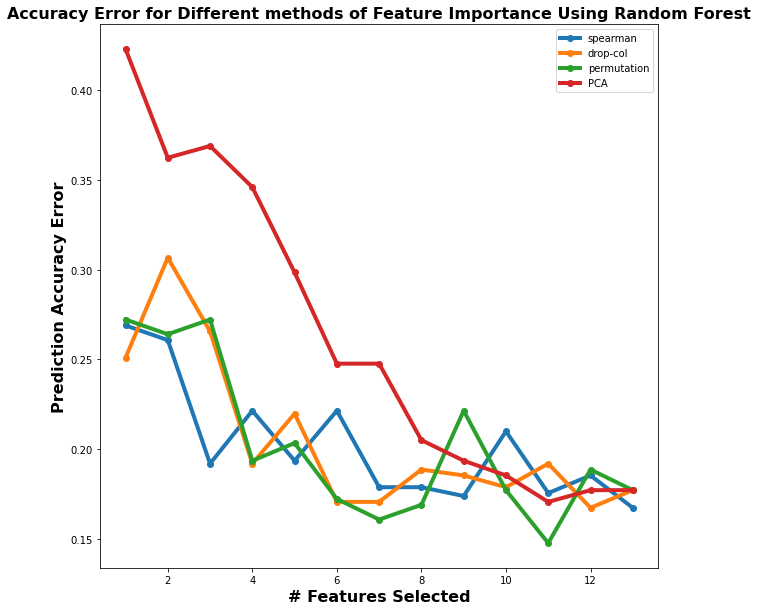

In [11]:
# Selected features contains the features selected by each method for k features
k = 13
all_scores, selected_features = compare_strat(k, PCA_features, spearman, dropped_avg, permute_avgs)
labels = ['spearman', 'drop-col', 'permutation', 'PCA']
plot_methods(k, all_scores, labels)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[21:55:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


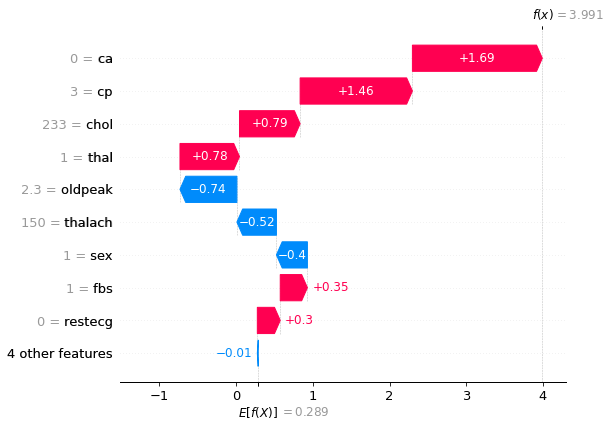

In [12]:
model = XGBClassifier()
model.fit(X, y)
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])

###  Examine how well each method performs in comparison to Shap using KendalTau's Rank Correlation Coefficient. For our case, **Spearman's R** Tau is the highest which means that its ranking of feature importance is most similar to the ground truth feature importance ranking

In [13]:
ground_truth = ['ca', 'cp', 'chol', 'thal', 'oldpeak', 'thalach', 'sex', 'fbs', 'restecg']
rank_truth = [i+1 for i in range(len(ground_truth))]
# Compare how each method 

i = len(X.columns)
feat_spear = get_best_features(spearman, i)
feat_drop =  get_best_features(dropped_avg, i, reverse=False)
feat_perm = get_best_features(permute_avgs, i, reverse=False)
feat_PCA = PCA_features[:i]

all_featimp = [feat_spear, feat_drop, feat_perm, feat_PCA]

for method, features in zip(labels, all_featimp):
    rank = [features.index(col)+1 for col in ground_truth]
    tau, p_value = stats.kendalltau(rank, rank_truth)
    print(f"METHOD {method};  Kenall's Tau: {tau}")
    

METHOD spearman;  Kenall's Tau: 0.611111111111111
METHOD drop-col;  Kenall's Tau: 0.5
METHOD permutation;  Kenall's Tau: 0.5
METHOD PCA;  Kenall's Tau: 0.3333333333333333


# Automatic Feature Selection

**Method**: 
1) Establish a benchmark validation error with all features included. <br>
2) Remove the least important feature and calculate the average validation score with that feature removed. <br>
3) Compare with the Benchmark to ensure the validation error is not dropping below the benchmark. <br>
4) Recalculate Spearman's rank for the features that are leftover. <br>
Iteratively go through 2, 3, and 4 and stop when the validation error is below the benchmark.

In [15]:
bench_avg = selected_features_score(X, y, X.columns, model=RandomForestClassifier(),n=10)
current_features, scores = remove_features(bench_avg)

BENCHMARK: 0.8163934426229508
SCORE: 0.821311475409836
SCORE: 0.8262295081967214
SCORE: 0.8360655737704918
SCORE: 0.8163934426229508
SCORE: 0.8049180327868852


CURRENT FEATURES: ['cp', 'exang', 'ca', 'thal', 'thalach', 'oldpeak', 'slope', 'sex', 'age']


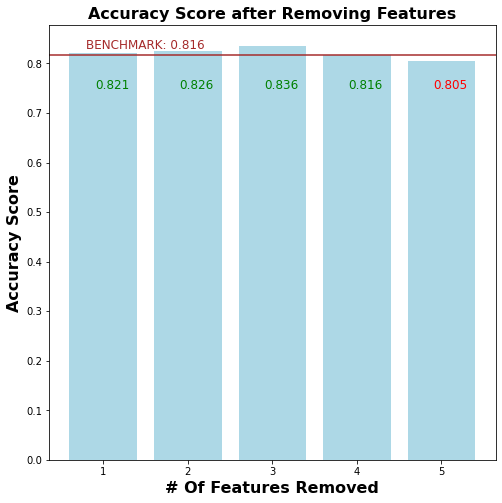

In [16]:
print("CURRENT FEATURES:", current_features)
plot_feature_removal(scores, bench_avg)

# Statistical Significance: Variance and Empirical p-values for Feature Importances
Many times, the feature importance calculated could be the result of noise. How do we test this? When choosing a method for feature importance, we can iterate through it multiple times to
To calculate the variances and standard deviation, we perform a MinMaxScaler to normalize the feature importances. We can see from the below graph that the 'fbs' column's feature importance is likely due to noise. If we run a hypothesis test with **a =. 0.05** we fail to reject the null hypothesis that the column's spearman's R is significant.

FixedFormatter should only be used together with FixedLocator


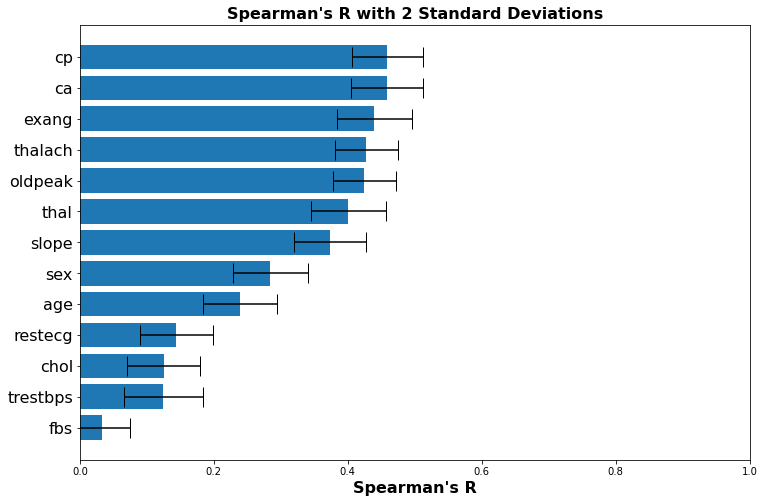

In [17]:
normalized = get_feature_variance(X)   # list of tuples (col, mean, variance)
plot_feature_variance(normalized)

# Permuting the Y-column:
**Purpose**: Determine if the feature importance is due to noise. <br>
**Explanation** We would expect that a feature's importance to not be higher than the baseline when the target column is permuted randomly. We perform a null distribution hypothesis test to check if the baseline feature importance is not due to random noise. <br>
**Method**:
1) Get baseline feature importance score for columns. <br>
2) For a set amount of iterations, randomly permute the target column and calculate the feature. <br>
3) Count the number of times the column's feature imporrtance is greater than the base. <br>
4) Divide each column's count by the total number of iterations. <br>
5) If the percentage > 0.05, reject the null hypothesis that the feature's importance score is due to random noise. <br>


### After randomly permuting the y-columns for and calculting the Spearman's R compared to the base, we can see that the 'fbs', 'restecg', and 'trestbps', and 'chol' columns had a 55.5%, 6.4%. 19.6%, and 19.6% chance of having their Spearman's R greater than their base. By conducting our hypothesis test, this suggests that these columns' feature importance scores were due to random noise 

{'age': 0.0, 'sex': 0.0, 'cp': 0.0, 'trestbps': 0.193, 'chol': 0.196, 'fbs': 0.555, 'restecg': 0.061, 'thalach': 0.0, 'exang': 0.0, 'oldpeak': 0.0, 'slope': 0.0, 'ca': 0.0, 'thal': 0.0}


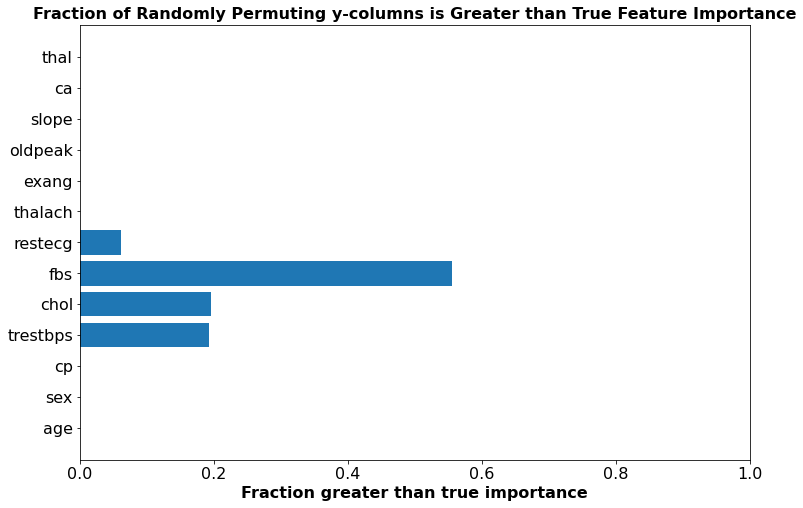

In [21]:
dic_pval = permute_y(X, 1000)   # Permute 1000 times
print(dic_pval)
plot_pval(dic_pval)

###  **Issue:** Drop-column and Permutation Importance doesnot deal with multi-collinear features
### **Reality:** In real-world problems, it is nearly impossible to determine if features are independent of each other. Generally, we should always assume that there is some multi-collinearity between features. How do we solve this issue? 
### **Solution:** Find the columns that are multi-collinear using a spearman's R matrix


### **Explanation**: This heat map is a matrix that shows each features correlation with other columns. If there is a high multi-collinearity between 2 features, we should **drop or permute the columns together**

<AxesSubplot:>

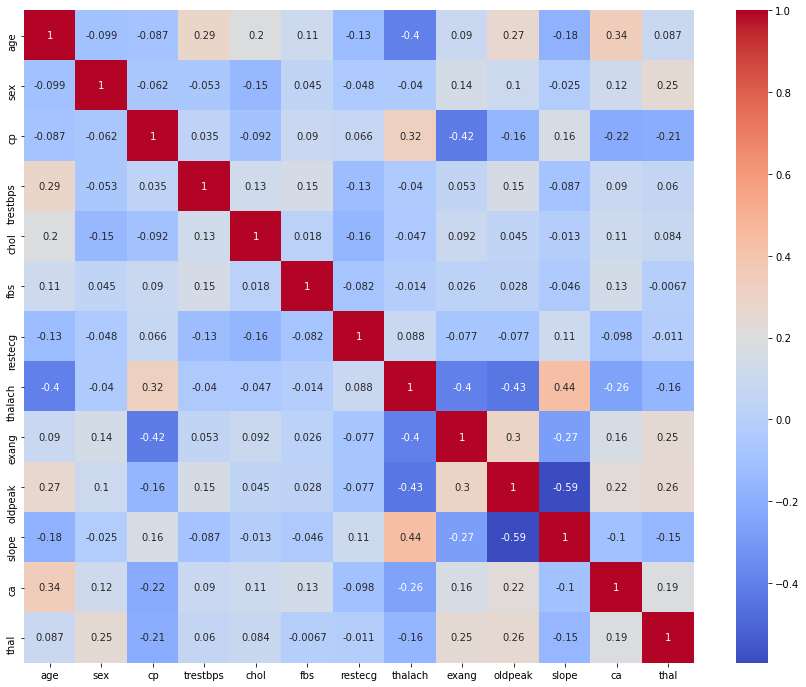

In [19]:
corr = X.corr(method='spearman')
plt.subplots(figsize=(15,12))
sns.heatmap(corr, annot=True, vmax=1, cmap='coolwarm')